In [1]:
# Install the necessary python libraries for this project

# - pandas
# - numpy
# - matplotlib
# - seaborn
# - librosa
# - IPython
# - scikit-learn
# - tensorflow

In [2]:
pip install pandas numpy matplotlib seaborn librosa IPython scikit-learn tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing necessary libraries for data manipulation, visualization, audio analysis, and model building

import pandas as pd  # for data manipulation and analysis
import numpy as np  # for numerical operations

import matplotlib.pyplot as plt  # for plotting graphs
import seaborn as sns  # for visualizing the data

import librosa  # for audio processing and feature extraction
import librosa.display

import os  # to read files from local directories

from sklearn.preprocessing import StandardScaler, OneHotEncoder  # for normalization and encoding
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score  # for model evaluation
from sklearn.model_selection import train_test_split  # for splitting the dataset

from IPython.display import Audio  # to play the audio files

from tensorflow.keras import utils  # Keras utility functions
from tensorflow.keras.models import Sequential  # to build neural network model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten  # Layers for CNN-LSTM hybrid

import warnings

warnings.filterwarnings('ignore')  # to suppress warnings

print("Modules imported.")

Modules imported.


In [2]:
# Set the path to the directory where the dataset is stored

data_path = r"C:\Users\DELL\Emotional Speech Data\TESS Toronto emotional speech set data\TESS Toronto emotional speech set data"

In [3]:
# Create lists to store the file paths and corresponding emotion labels

audio_files = []
emotions = []

# Walk through the data directory and append file paths and labels

for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):  # Process only .wav files
            audio_files.append(os.path.join(root, file))
            
            # Extract emotion from filename
            
            emotion = file.split('_')[-1]
            emotion = emotion.split('.')[0]
            emotions.append(emotion.lower())

In [4]:
# Create a DataFrame to store the data paths and labels

df = pd.DataFrame()
df['speech_dir'] = audio_files
df['emotion_label'] = emotions

print("Dataset is fully loaded.")

Dataset is fully loaded.


In [5]:
# Display the dataset summary

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   speech_dir     2800 non-null   object
 1   emotion_label  2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB


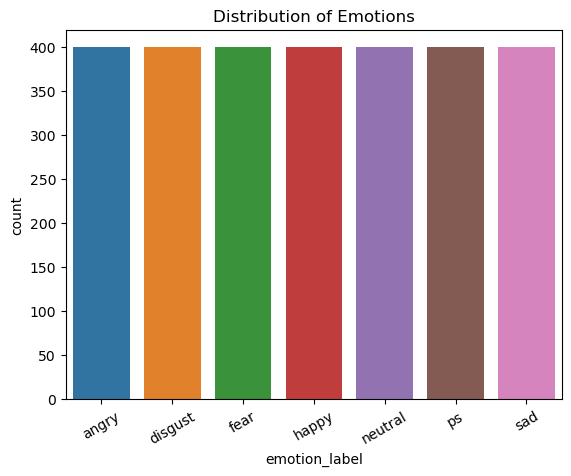

In [6]:
# Visualize the distribution of emotions in the dataset

sns.countplot(x='emotion_label', data=df)
plt.title("Distribution of Emotions")
plt.xticks(rotation=30)
plt.show()

In [7]:
# Function to visualize waveplots of the audio

def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=18)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

# Function to visualize spectrograms of the audio

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)  # Short-Time Fourier Transform
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=18)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

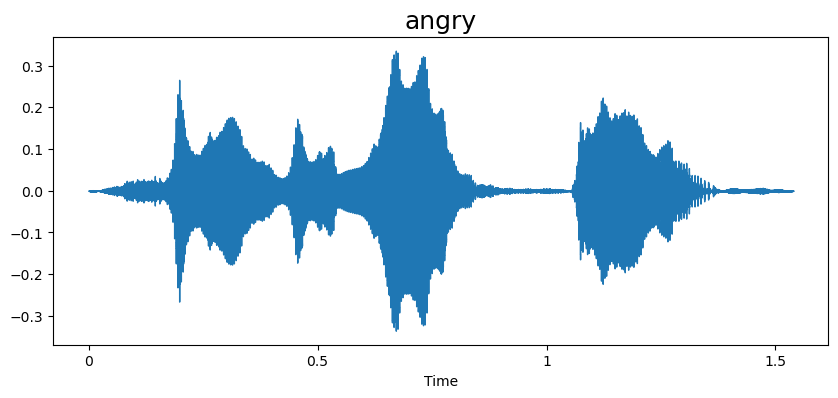

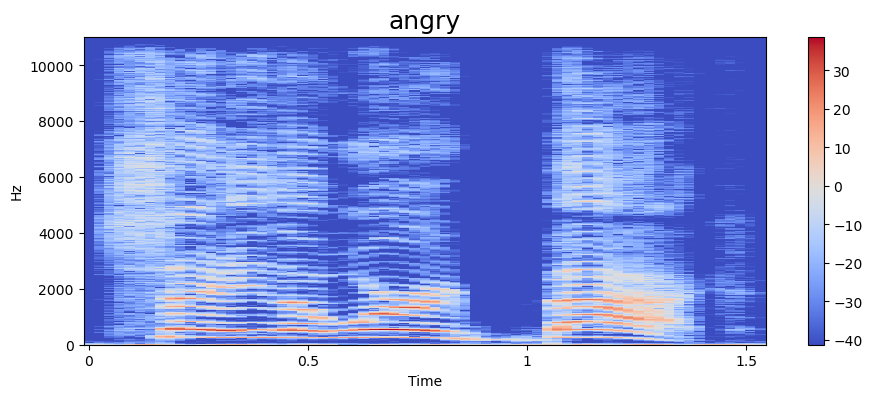

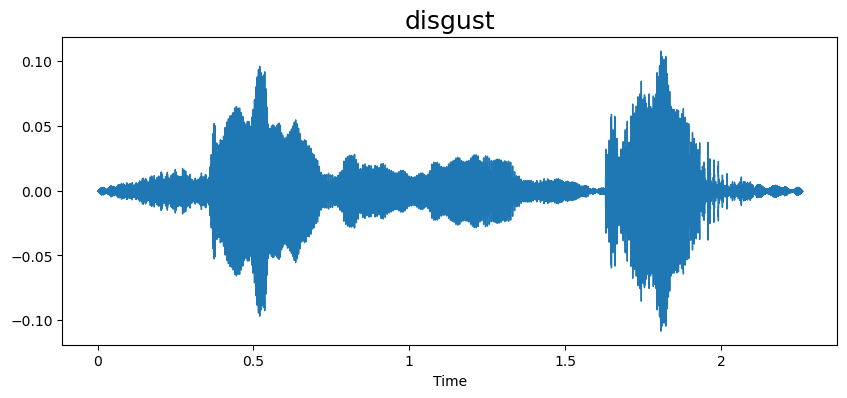

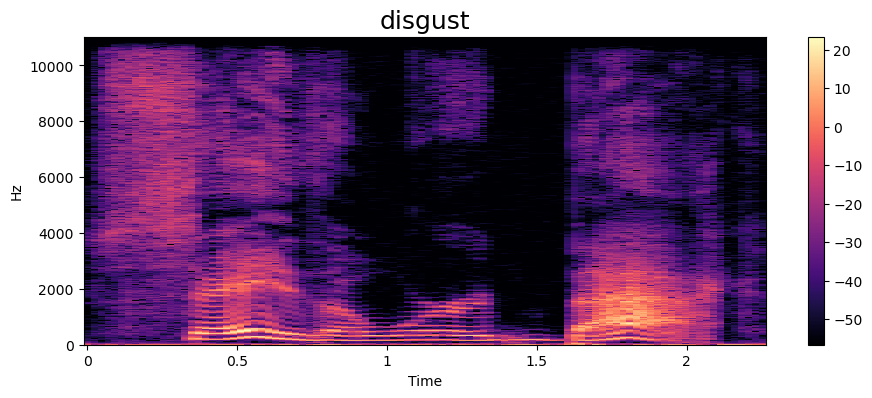

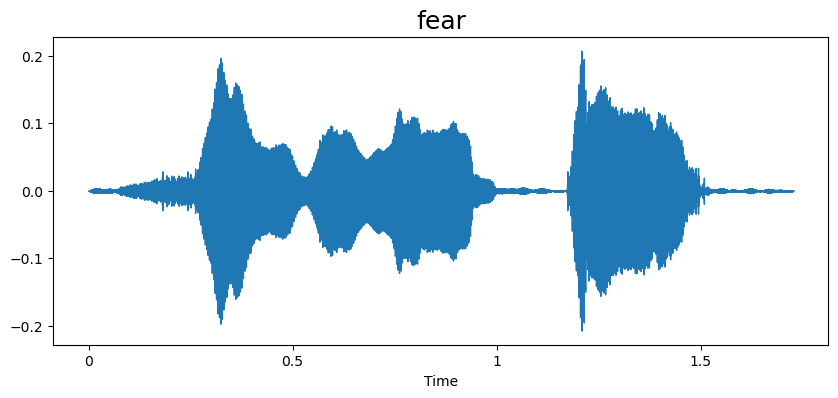

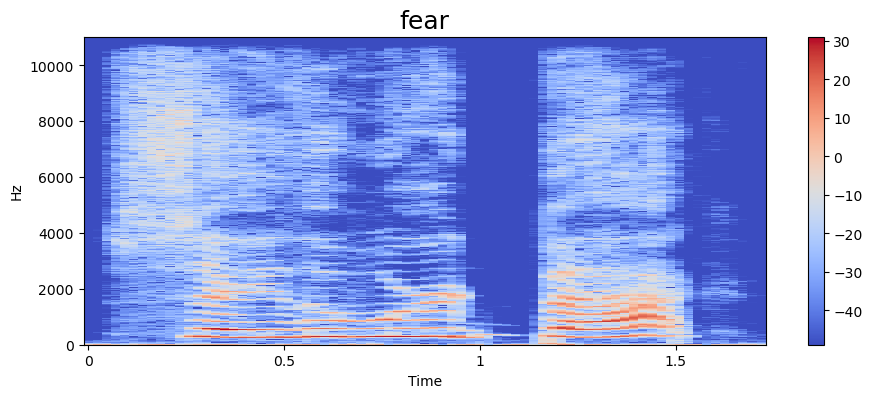

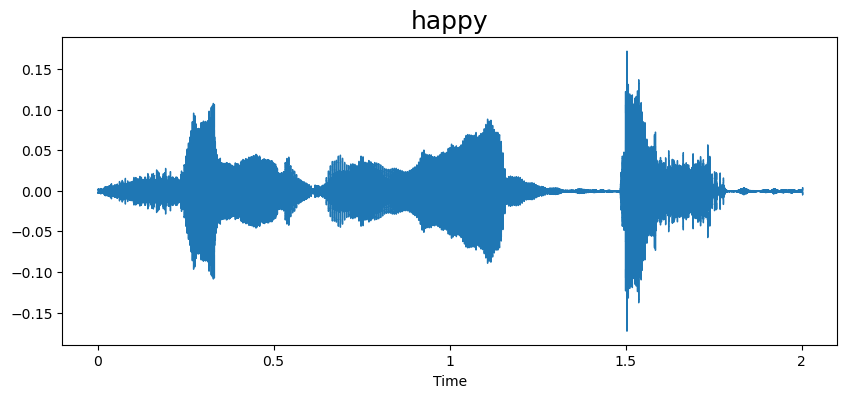

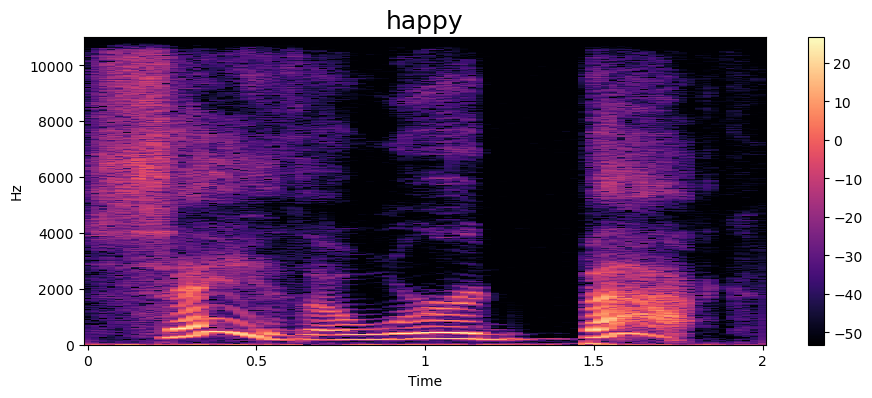

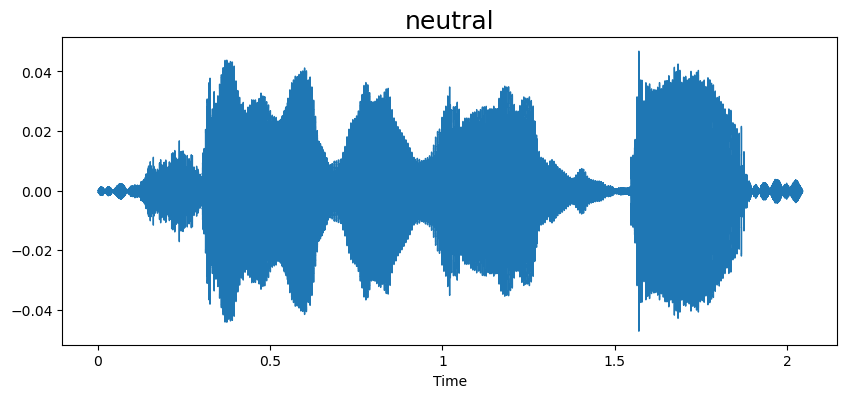

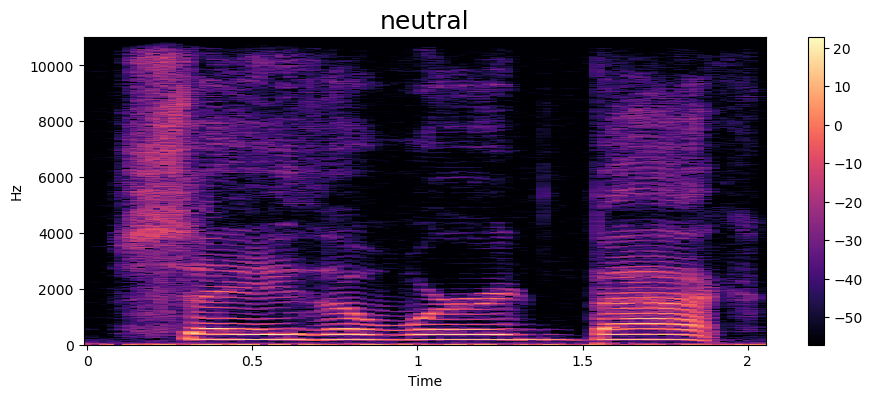

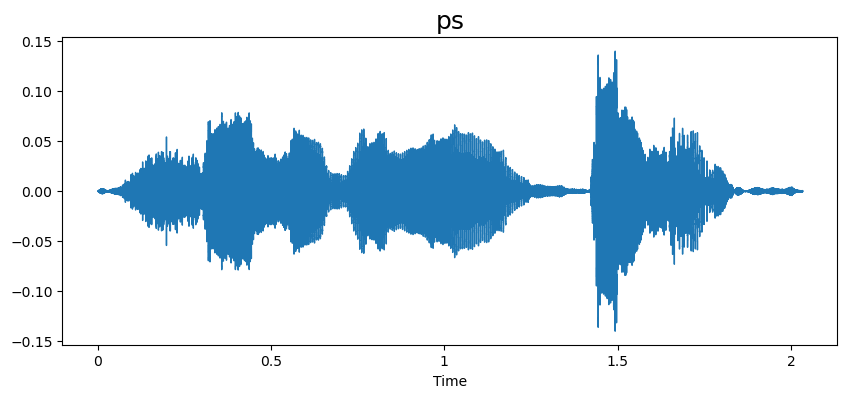

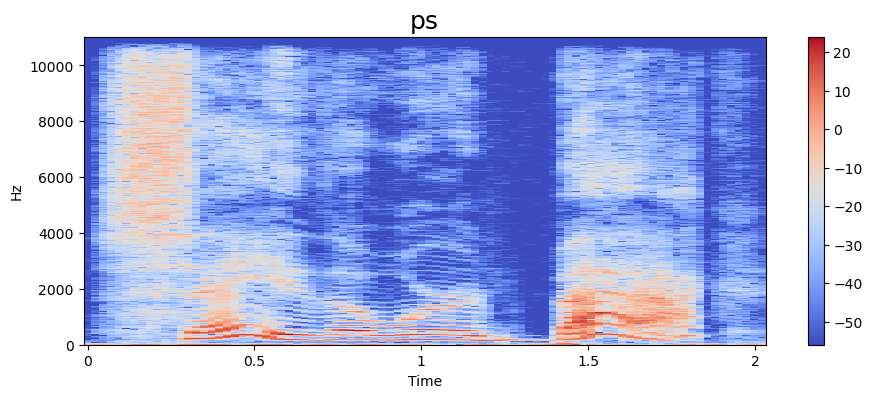

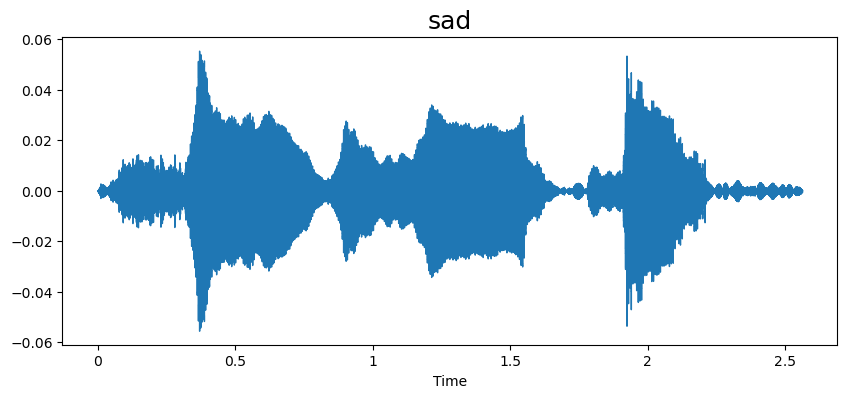

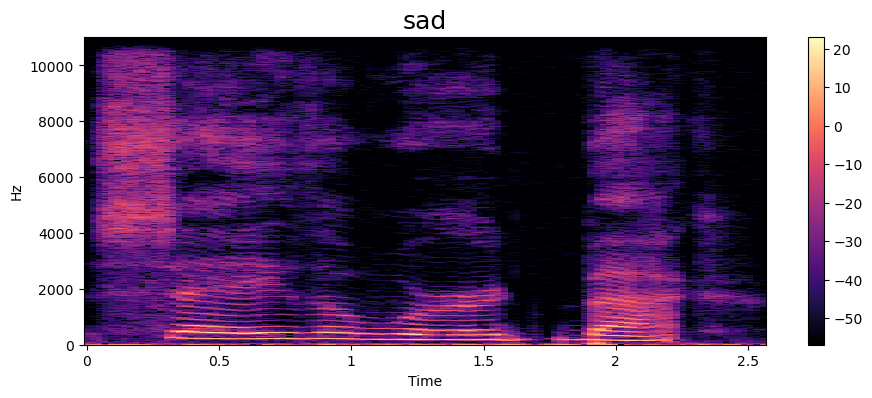

In [8]:
# Loop through emotions and visualize waveform and spectrogram for each

emotion_id = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

for emotion in emotion_id:
    
    # Get the file path for the first sample of each emotion
    
    path = np.array(df['speech_dir'][df['emotion_label'] == emotion])[0]

    # Load the audio file
    
    data, sampling_rate = librosa.load(path)

    # Plot the waveform
    
    waveplot(data, sampling_rate, emotion)

    # Plot the spectrogram
    
    spectrogram(data, sampling_rate, emotion)

    # Play the audio
    
    display(Audio(path))

In [12]:
# Data Augmentation Function

def augment_audio(file):
    y, sr = librosa.load(file, sr=22050, duration=3, offset=0.5)
    
    # Pitch shifting
    
    y_pitch_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

    # Adding noise
    
    noise_factor = 0.005 * np.random.randn(len(y))
    y_noisy = y + noise_factor
    
    # Time stretching
    
    y_stretch = librosa.effects.time_stretch(y, rate=1.1)

    return y_pitch_shifted, y_noisy, y_stretch

In [21]:
# Feature Extraction Function

def extract_features(y, sr):
    """
    Extracts features from audio data.

    Parameters:
    - y: Audio time series
    - sr: Sample rate of the audio

    Returns:
    - Combined features (MFCC, Chroma, Spectral Contrast)
    """
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)  # Extract MFCC features
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)  # Extract Chroma features
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)  # Extract Spectral Contrast
    return np.hstack((mfcc, chroma, spectral_contrast))  # Combine features

In [22]:
X = []  # Features
y = []  # Labels

# Extract features for original and augmented audio

for file in df['speech_dir']:
    
    # Extract features from original audio
    
    features = extract_features(*librosa.load(file, sr=22050, duration=3, offset=0.5))  # Load and extract features
    X.append(features)
    
    # Append the corresponding label
    
    emotion_label = df['emotion_label'][df['speech_dir'] == file].values[0]
    y.append(emotion_label)

    # Augment the audio and extract features
    
    y_pitch_shifted, y_noisy, y_stretch = augment_audio(file)
    for augmented_audio in [y_pitch_shifted, y_noisy, y_stretch]:
        X.append(extract_features(augmented_audio, 22050))  # Pass audio and sample rate
        y.append(emotion_label)  # Append the same label for augmented versions

In [23]:
# Convert to numpy array
X = np.array(X)
y = np.array(y)

# Check the shapes
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

Features shape: (11200, 59), Labels shape: (11200,)


In [24]:
# Normalize input features using StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
# Encode categorical variables (emotions)

enc = OneHotEncoder()
y_encoded = enc.fit_transform(y.reshape(-1, 1)).toarray()  # Reshape y to 2D for OneHotEncoder

In [30]:
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

In [31]:
# Defining the CNN-LSTM hybrid model

model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # Adjust input shape
    Dropout(0.5),
    LSTM(128, return_sequences=False),  # LSTM layer with return_sequences=False
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_encoded.shape[1], activation='softmax')  # Use y_encoded for output layer
])

In [32]:
# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()  # Display model architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 59, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 59, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 470,023 (1.79 MB)

 Trainable params: 470,023 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the model

history = model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, 
                    validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test),
                    epochs=30, batch_size=64)

Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - accuracy: 0.2176 - loss: 1.8398 - val_accuracy: 0.6329 - val_loss: 0.9806
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.5929 - loss: 1.0522 - val_accuracy: 0.7804 - val_loss: 0.5746
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.7789 - loss: 0.6115 - val_accuracy: 0.9018 - val_loss: 0.3257
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - accuracy: 0.8488 - loss: 0.4817 - val_accuracy: 0.9121 - val_loss: 0.2727
Epoch 5/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.9162 - loss: 0.3116 - val_accuracy: 0.9229 - val_loss: 0.2686
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.9126 - loss: 0.3103 - val_accuracy: 0.9407 - val_loss: 0.1910
Epoch 7/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9393 - loss: 0.2241 - val_accuracy: 0.9532 - val_loss: 0.1574
Epoch 8/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.9443 - loss: 0

In [34]:
# Evaluate the model

y_pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


In [35]:
# Calculate confusion matrix and classification report

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[428   2   0   0   0   0   0]
 [  1 382   0   0   2   1   1]
 [  3   0 393   0   0   0   0]
 [  2   2   0 385   0   4   0]
 [  0   0   0   0 390   0   0]
 [  4  16   0   1   0 395   0]
 [  0   1   0   0   0   0 387]]


In [36]:
target_names = enc.categories_[0]  # Extract target names from encoder
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=target_names))

Classification Report:
               precision    recall  f1-score   support

       angry       0.98      1.00      0.99       430
     disgust       0.95      0.99      0.97       387
        fear       1.00      0.99      1.00       396
       happy       1.00      0.98      0.99       393
     neutral       0.99      1.00      1.00       390
          ps       0.99      0.95      0.97       416
         sad       1.00      1.00      1.00       388

    accuracy                           0.99      2800
   macro avg       0.99      0.99      0.99      2800
weighted avg       0.99      0.99      0.99      2800



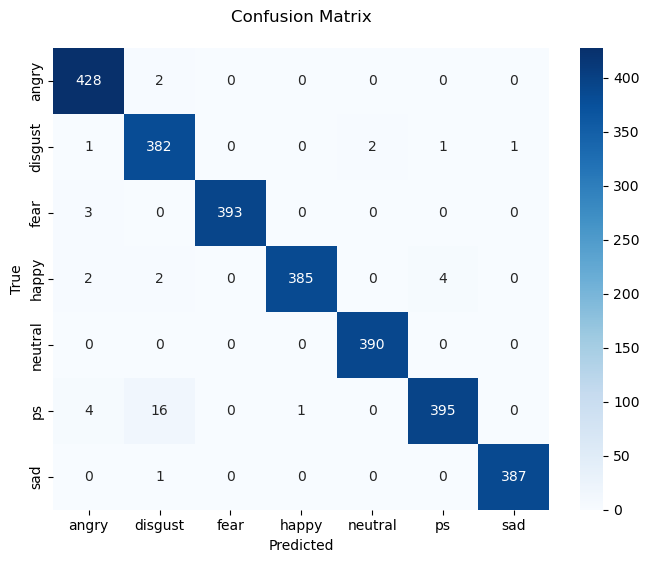

In [37]:
# Plot confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix\n')
plt.show()

In [38]:
# Save the model

model.save("cnn_lstm_speech_emotion_recognition_project.keras")

In [39]:
print("Model saved.")

Model saved.
